In [2]:
import sys
from pathlib import Path

sys.path.append(r"/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.lines as mlines
from textwrap import dedent
from linearmodels.panel import PanelOLS
from io import StringIO
from sklearn.preprocessing import StandardScaler

from data_analysis.data_fetcher.data_fetcher_class import DataFetcher
from data_collection.consts import  DB_PARAMS

In [3]:
fetcher = DataFetcher(
    db_params=DB_PARAMS,
    reports_table="reports",
    targets_table="targets_yf",
)

Available regressors:
 - avg_default_verbolizer
 - avg_shrink_verbolizer
 - doc_len
 - eps_surprise
 - f_size
 - full_list_default_verbolizer
 - full_list_shrink_verbolizer
 - hv_orig_score
 - lm_orig_score
 - max_abs_default
 - max_abs_shrink
 - max_default_verbolizer
 - max_shrink_verbolizer
 - md_hv1
 - md_hv2
 - md_hv3
 - md_lm1
 - md_lm2
 - md_lm3
 - min_default_verbolizer
 - min_shrink_verbolizer
 - stretch_default
 - stretch_shrink
Available sectors:
 - Technology (92)
 - Industrials (86)
 - Financial Services (85)
 - Healthcare (66)
 - Consumer Cyclical (58)
 - Consumer Defensive (40)
 - Real Estate (32)
 - Utilities (32)
 - Energy (30)
 - Basic Materials (23)
 - Communication Services (22)


/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [4]:
df = fetcher.fetch_data(
      regressors=[
       'avg_default_verbolizer', 
       'avg_shrink_verbolizer',
       'max_abs_default',
       'max_abs_shrink',
        'max_default_verbolizer',
        'max_shrink_verbolizer',
        'min_default_verbolizer',
        'min_shrink_verbolizer',
        'eps_surprise',
        'f_size',
        'doc_len'
       ],
   prepare_fixed_effects=True
)

/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:130: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:161: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:169: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBA

In [5]:
df.isna().sum()

report_type                 0
avg_default_verbolizer      0
avg_shrink_verbolizer       0
max_abs_default             0
max_abs_shrink              0
max_default_verbolizer      0
max_shrink_verbolizer       0
min_default_verbolizer      0
min_shrink_verbolizer       0
eps_surprise                0
f_size                      0
doc_len                     0
two_day_r                 480
three_day_r                 0
four_day_r                  0
five_day_r                  0
six_day_r                   0
seven_day_r                 0
full_q_r                  496
two_day_e_r               480
three_day_e_r               0
four_day_e_r                0
five_day_e_r                0
six_day_e_r                 0
seven_day_e_r               0
full_q_e_r                496
two_day_abn_r               0
three_day_abn_r             0
four_day_abn_r              0
five_day_abn_r              0
six_day_abn_r               0
seven_day_abn_r             0
full_q_abn_r              496
two_day_r_

In [6]:
df.columns

Index(['report_type', 'avg_default_verbolizer', 'avg_shrink_verbolizer',
       'max_abs_default', 'max_abs_shrink', 'max_default_verbolizer',
       'max_shrink_verbolizer', 'min_default_verbolizer',
       'min_shrink_verbolizer', 'eps_surprise', 'f_size', 'doc_len',
       'two_day_r', 'three_day_r', 'four_day_r', 'five_day_r', 'six_day_r',
       'seven_day_r', 'full_q_r', 'two_day_e_r', 'three_day_e_r',
       'four_day_e_r', 'five_day_e_r', 'six_day_e_r', 'seven_day_e_r',
       'full_q_e_r', 'two_day_abn_r', 'three_day_abn_r', 'four_day_abn_r',
       'five_day_abn_r', 'six_day_abn_r', 'seven_day_abn_r', 'full_q_abn_r',
       'two_day_r_vol', 'three_day_r_vol', 'four_day_r_vol', 'five_day_r_vol',
       'six_day_r_vol', 'seven_day_r_vol', 'full_q_r_vol'],
      dtype='object')

In [15]:
class FEModeler:
    """
    A class to run panel fixed effects regressions using PanelOLS
    and extract key parameter statistics for a specified regressor.

    Attributes:
        df: The input panel data.
        var_names: Column names of the input DataFrame.
        params_dict: Dictionary storing regression parameters for each independent variable.
    """

    def __init__(self, df: pd.DataFrame, scale: bool = False):
        """
        Initialize the FEModeler with panel data.

        Args:
            df: Panel DataFrame with MultiIndex (entity, time).
            scale: Whether to standardize the regressors.
        """
        self.original_df = df.copy()
        self.df = df.copy()
        self.var_names = df.columns
        self.params_dict = {}
        self.scale = scale

        if scale:
            self._scale_regressors()

    def _scale_regressors(self):
        """
        Standardize regressors: columns 1 to 8 (your x variables), plus control variables eps_surprise, f_size.
        Scaling is done entity-wise (within-entity).
        """
        x_cols = list(self.df.columns[1:9]) + ['eps_surprise', 'f_size']
        scaler = StandardScaler()

        # Scale within each entity group
        for entity in self.df.index.get_level_values(0).unique():
            entity_mask = self.df.index.get_level_values(0) == entity
            sub_df = self.df.loc[entity_mask, x_cols]
            if sub_df.shape[0] < 2:
                continue
            self.df.loc[entity_mask, x_cols] = scaler.fit_transform(sub_df)


    @staticmethod
    def extract_params(summary, regressor_name: str) -> pd.Series:
        """
        Extract parameter statistics for a given regressor from the regression summary.

        Args:
            summary: The PanelOLS regression summary object.
            regressor_name: The name of the regressor to extract parameters for.

        Returns:
            A Series containing coefficient, std error, p-value, and confidence intervals.
        """
        coef_table = summary.tables[1].as_html()
        coef_table_io = StringIO(coef_table)
        df = pd.read_html(coef_table_io, header=0, index_col=0)[0]
        df.columns = ['Parameter', 'std_err', 'T-stat', 'P-value', 'Lower CI', 'Upper CI']
        return df.loc[regressor_name, ['Parameter', 'std_err', 'P-value', 'Lower CI', 'Upper CI']].copy()

    def fit(self, data: pd.DataFrame, formula: str):
        """
        Fit a fixed effects regression model using PanelOLS.

        Args:
            data: A subset of the full DataFrame containing required variables.
            formula: Regression formula in Patsy-style syntax.

        Returns:
            The regression summary object.
        """
        model = PanelOLS.from_formula(formula, data=data, check_rank=True)
        result = model.fit(cov_type='kernel')
        return result.summary

    def compute(self) -> dict[str, list[pd.Series]]:
        """
        Run fixed effects regressions for all combinations of independent and dependent variables,
        and store the parameter summaries for each independent variable.

        Returns:
            A dictionary where keys are independent variable names,
            and values are lists of Series with parameter info for each dependent variable.
        """
        targets = ['returns', 'e_returns', 'abn_returns', 'r_vol']
        time_frames = ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter' ]

        var_names = self.df.columns 

        for x in range(1, 9):
            # Targets starts from y index
            y = 12

            per_target_params = {}
            for target in targets:  
                if target not in per_target_params:
                    per_target_params[target] = {}

                for frame in time_frames:
                    print(self.df.columns[x], self.df.columns[y])

                    data = self.df.iloc[:, [x, 9, 10, 11, y]].dropna().copy()

                    formula = f"{var_names[y]} ~ {var_names[x]} + eps_surprise + f_size + doc_len + EntityEffects + TimeEffects"
                    try:
                        result_summary = self.fit(data, formula)
                        print(result_summary)
                        param_info = self.extract_params(result_summary, self.var_names[x])
                        per_target_params[target][self.df.columns[y]] = param_info
                        
                    except Exception as e:
                        print(e)
                    y += 1

            self.params_dict[self.df.columns[x]] = per_target_params

        return self.params_dict
    
    def get_dict(self):
        res = self.params_dict
        dict_for_json = {}

        for x in res:
            if x not in dict_for_json.keys():
                dict_for_json[x] = {}

            for y in res[x]:
                if y not in dict_for_json[x].keys():
                    dict_for_json[x][y] = {}

                for z in res[x][y]:
                    dict_for_json[x][y][z] = res[x][y][z].to_dict()
    
        return dict_for_json
    
    def get_latex_table(self):
        REGRESSOR_ORDER = [                            # optional enforced order
            'avg_default_verbolizer', 'avg_shrink_verbolizer',
            'max_abs_default', 'max_abs_shrink', 'max_default_verbolizer',
            'max_shrink_verbolizer', 'min_default_verbolizer',
            'min_shrink_verbolizer',
        ]
        TARGET_ORDER    = ["returns", "e_returns", "abn_returns", "r_vol"]
        WINDOWS = [                           # (prefix in JSON, label in table)
            ("two_day",  "2d"),
            ("three_day","3d"),
            ("four_day", "4d"),
            ("five_day", "5d"),
            ("six_day",  "6d"),
            ("seven_day","7d"),
            ("full_q",   "full Q"),
        ]
        TABLE_HEADER = dedent(r"""
            \FloatBarrier
            \setcellgapes{2pt}\makegapedcells
            \begin{center}\small
            \begin{longtable}{ll*{7}{c}}
            \caption{Coefficients with robust SEs in parentheses. Significance:
              $^{*}\,p<0.05$, $^{**}\,p<0.01$, $^{***}\,p<0.001$.}
              \label{tab:full-longtable}\\
            \toprule
            \multicolumn{2}{l}{} & \multicolumn{7}{c}{Return-window}\\
            \cmidrule(l){3-9}
            Regressor & Target & 2d & 3d & 4d & 5d & 6d & 7d & full Q\\
            \midrule
            \endfirsthead
        
            \toprule
            \multicolumn{2}{l}{} & \multicolumn{7}{c}{Return-window (continued)}\\
            \cmidrule(l){3-9}
            Regressor & Target & 2d & 3d & 4d & 5d & 6d & 7d & full Q\\
            \midrule
            \endhead
        
            \midrule \multicolumn{9}{r}{\emph{Continued on next page}}\\
            \endfoot
        
            \bottomrule
            \endlastfoot
        """)
        
        TABLE_TAIL = dedent(r"""
            \end{longtable}
            \end{center}
            \FloatBarrier
        """)
        CONTROLS_NOTE = (
            r"\multicolumn{9}{l}{\textit{Controls included:}"
            r" firm fixed effects, time fixed effects, firm size, EPS surprise}\\"
        )


        def star(p: float) -> str:
            """Return significance stars for a p-value."""
            if p < 0.001:
                return "***"
            if p < 0.01:
                return "**"
            if p < 0.05:
                return "*"
            return ""
        
        def cs(coef, se, p) -> str:
            """Return the \\cs{coef}{se}{stars} micro-syntax."""
            # .3f keeps everything to 3 decimals – change if you prefer
            return fr"\cs{{{coef:.3f}}}{{{se:.3f}}}{{{star(p)}}}"
        
        def fetch_window(tgt_dict: dict, prefix: str):
            """
            Return a dict with 'coef', 'se', 'p' for the first key whose name
            *starts with* `prefix`.  If none exist, return None.
            """
            for k, v in tgt_dict.items():
                if k.startswith(prefix):
                    return {
                        "coef": v.get("Parameter", v.get("coef")),
                        "se":   v.get("std_err",  v.get("se")),
                        "p":    v.get("P-value",  v.get("p", 1.0)),
                    }
            return None  # not found
        
        def latex_escape(s: str) -> str:
            return s.replace("_", r"\_")
        
        def make_table_body(results: dict) -> str:
            """Build the LaTeX rows for the longtable; never keys-out."""
            lines = []
        
            for reg in REGRESSOR_ORDER:
                if reg not in results:
                    continue
                
                reg_dict = results[reg]
                n_targets = sum(1 for t in TARGET_ORDER if t in reg_dict)
                first_row = True
        
                for tgt in TARGET_ORDER:
                    if tgt not in reg_dict:
                        continue
                    
                    tgt_dict = reg_dict[tgt]
                    cells = []
        
                    for prefix, _label in WINDOWS:
                        entry = fetch_window(tgt_dict, prefix)
                        if entry:
                            cells.append(cs(entry["coef"], entry["se"], entry["p"]))
                        else:
                            cells.append(r"\cs{--}{--}{}")  # placeholder
        
                    if first_row:
                        label = fr"\multirow[t]{{{n_targets}}}{{*}}{{{latex_escape(reg)}}}"
                        first_row = False
                    else:
                        label = " " * 12  # keeps the .tex source tidy
        
                    lines += [
                        rf"{label} & {latex_escape(tgt)} & " + " & ".join(cells) + r" \\",
                        r"\cline{2-9}",
                    ]
        
                # change the last \cline in this block to \midrule
                lines[-1] = r"\midrule"
        
            # drop the very last \midrule
            lines.pop()
            lines.append(CONTROLS_NOTE)

            return "\n".join(lines)
        
        if not self.params_dict:
            self.compute()
        
        params_dict = self.get_dict()
        body = make_table_body(params_dict)
        
        return TABLE_HEADER + body + TABLE_TAIL
    
    def plot_all_params(self):
        """
        Plot bar charts for each regressor–target combination.
        Each chart shows 7 timeframes with confidence intervals.
        """
        for regressor, target_dict in self.params_dict.items():
            for target, outcomes in target_dict.items():
                keys = list(outcomes.keys())
                if len(keys) < 1:
                    continue

                x = np.arange(len(keys))
                params = [outcomes[k]['Parameter'] for k in keys]
                lower = [outcomes[k]['Lower CI'] for k in keys]
                upper = [outcomes[k]['Upper CI'] for k in keys]

                plt.figure(figsize=(8, 6))
                plt.bar(x, params, width=0.4, color='tab:blue', label=regressor)

                # Confidence intervals
                for i in range(len(keys)):
                    plt.plot([x[i], x[i]], [lower[i], upper[i]], color='black', linewidth=1.5)

                plt.axhline(0, color='black', linewidth=1)
                plt.xticks(x, keys, rotation=45)
                plt.title(f"{regressor} on {target}")
                plt.xlabel('Time frame')
                plt.ylabel('Beta coefficient')
                plt.tight_layout()

                ci_legend = mlines.Line2D([], [], color='black', linewidth=1.5, label='95% CI')
                plt.legend(handles=[ci_legend])
                plt.show()
                
    def graph_3d(self):
        """
        Plot one 3D chart per regressor with beta bars across:
        - X: timeframes
        - Y: targets (sorted by |first beta| descending)
        - Z: beta value
        Includes confidence intervals and colors by target.
        """
        timeframes = ['two_day', 'three_day', 'four_day', 'five_day', 'six_day', 'seven_day', 'full_q']
        tf_labels = ['2d', '3d', '4d', '5d', '6d', '7d', 'fq']
        targets = ['returns', 'e_returns', 'abn_returns', 'r_vol']
        suffixes = {'returns': 'r', 'e_returns': 'e_r', 'abn_returns': 'abn_r', 'r_vol': 'r_vol'}
        for regressor, target_dict in self.params_dict.items():
            fig = plt.figure(figsize=(8, 12))
            ax = fig.add_subplot(111, projection='3d')
            # --- Sort targets by abs(first_beta) ---
            sort_metric = {}
            for target in targets:
                suffix = suffixes[target]
                key = f"{timeframes[0]}_{suffix}"
                try:
                    sort_metric[target] = target_dict[target][key]['Parameter']
                except KeyError:
                    sort_metric[target] = -np.inf  # push missing to the front
            sorted_targets = sorted(targets, key=lambda t: sort_metric[t])  # high to low
            # Positions
            n_targets = len(targets)
            n_frames = len(timeframes)
            x_pos, y_pos = np.meshgrid(np.arange(n_frames), np.arange(n_targets))
            x_pos = x_pos.flatten()
            y_pos = y_pos.flatten()
            z_pos = np.zeros_like(x_pos)
            dx = dy = 0.4
            # Collect values
            dz, ci_l, ci_u = [], [], []
            for target in sorted_targets:
                suffix = suffixes[target]
                for tf in timeframes:
                    key = f"{tf}_{suffix}"
                    try:
                        series = target_dict[target][key]
                        dz.append(series['Parameter'])
                        ci_l.append(series['Lower CI'])
                        ci_u.append(series['Upper CI'])
                    except KeyError:
                        dz.append(0)
                        ci_l.append(0)
                        ci_u.append(0)
            dz = np.array(dz)
            ci_l = np.array(ci_l)
            ci_u = np.array(ci_u)
            # Colors per target
            color_map = plt.colormaps.get_cmap('tab10')
            bar_colors = []
            for i in range(n_targets):
                bar_colors.extend([color_map(i / n_targets)] * n_frames)
            # Draw bars
            ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=bar_colors, alpha=0.6, shade=True)
            # Draw confidence interval lines
            for i, (x, y, z, low, high) in enumerate(zip(x_pos, y_pos, dz, ci_l, ci_u)):
                ax.plot([x + dx / 2, x + dx / 2], [y + dy / 2, y + dy / 2], [low, high],
                        color='black', linewidth=1.5, zorder=10)
            # Axes setup
            ax.set_xlabel('Timeframe')
            ax.set_ylabel('Target', labelpad=15)
            ax.set_zlabel('')  # remove default
            z_max = np.nanmax(ci_u)

# Place the label directly at the Z-axis tip visually
            ax.text(x=0, y=-2.0, z=z_max + 0.02,
                    s='Beta', fontsize=13, ha='center', va='bottom',
                    rotation=0, weight='bold', zorder=1000)

            #fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)

            ax.set_xticks(np.arange(n_frames) + dx / 2)
            ax.set_xticklabels(tf_labels)
            ax.set_yticks(np.arange(n_targets) + dy / 2)
            ax.set_yticklabels(sorted_targets)
            ax.set_title(f"Beta Coefficients for Regressor: {regressor}")
            plt.tight_layout()
            plt.show()


In [8]:
df.isna().sum()

report_type                 0
avg_default_verbolizer      0
avg_shrink_verbolizer       0
max_abs_default             0
max_abs_shrink              0
max_default_verbolizer      0
max_shrink_verbolizer       0
min_default_verbolizer      0
min_shrink_verbolizer       0
eps_surprise                0
f_size                      0
doc_len                     0
two_day_r                 480
three_day_r                 0
four_day_r                  0
five_day_r                  0
six_day_r                   0
seven_day_r                 0
full_q_r                  496
two_day_e_r               480
three_day_e_r               0
four_day_e_r                0
five_day_e_r                0
six_day_e_r                 0
seven_day_e_r               0
full_q_e_r                496
two_day_abn_r               0
three_day_abn_r             0
four_day_abn_r              0
five_day_abn_r              0
six_day_abn_r               0
seven_day_abn_r             0
full_q_abn_r              496
two_day_r_

In [9]:
df['f_size'] = df['f_size'] / 10**11

In [17]:
model.params_dict

{'avg_default_verbolizer': {'returns': {'two_day_r': Parameter    0.8928
   std_err      0.7517
   P-value      0.2350
   Lower CI    -0.5807
   Upper CI     2.3663
   Name: avg_default_verbolizer, dtype: float64,
   'three_day_r': Parameter    0.6406
   std_err      0.6511
   P-value      0.3252
   Lower CI    -0.6356
   Upper CI     1.9168
   Name: avg_default_verbolizer, dtype: float64,
   'four_day_r': Parameter    0.4156
   std_err      0.5113
   P-value      0.4164
   Lower CI    -0.5867
   Upper CI     1.4179
   Name: avg_default_verbolizer, dtype: float64,
   'five_day_r': Parameter    0.3350
   std_err      0.4521
   P-value      0.4587
   Lower CI    -0.5512
   Upper CI     1.2212
   Name: avg_default_verbolizer, dtype: float64,
   'six_day_r': Parameter    0.2660
   std_err      0.4178
   P-value      0.5243
   Lower CI    -0.5530
   Upper CI     1.0851
   Name: avg_default_verbolizer, dtype: float64,
   'seven_day_r': Parameter    0.0944
   std_err      0.4460
   P-value   

In [16]:
model = FEModeler(df=df, scale=False)
res = model.compute()

avg_default_verbolizer two_day_r
                          PanelOLS Estimation Summary                           
Dep. Variable:              two_day_r   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.0385
No. Observations:               12804   R-squared (Within):              -0.0003
Date:                Fri, May 16 2025   R-squared (Overall):              0.0016
Time:                        17:05:37   Log-likelihood                -2.936e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      0.7113
Entities:                         495   P-value                           0.5841
Avg Obs:                       25.867   Distribution:                 F(4,12278)
Min Obs:                       1.0000                                           
Max Obs:                       27.000   F-statistic (robust):             1.

avg_default_verbolizer two_day_r
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:              two_day_r   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.0385
No. Observations:               12804   R-squared (Within):              -0.0003
Date:                Fri, May 16 2025   R-squared (Overall):              0.0016
Time:                        17:05:37   Log-likelihood                -2.936e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      0.7113
Entities:                         495   P-value                           0.5841
Avg Obs:                       25.867   Distribution:                 F(4,12278)
Min Obs:                       1.0000                                           
Max Obs:                       27.000   F-statistic (robust):             1.1294
                                        P-value                           0.3405
Time periods:                      28   Distribution:                 F(4,12278)
Avg Obs:                       457.29                                           
Min Obs:                       2.0000                                           
Max Obs:                       493.00                                           
                                                                                
                                   Parameter Estimates                                    
==========================================================================================
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
avg_default_verbolizer     0.8928     0.7517     1.1876     0.2350     -0.5807      2.3663
eps_surprise               -4e-06  4.727e-06    -0.8463     0.3974  -1.327e-05   5.265e-06
f_size                    -0.0130     0.0181    -0.7202     0.4714     -0.0485      0.0224
doc_len                 2.079e-07  2.216e-07     0.9380     0.3482  -2.265e-07   6.423e-07
==========================================================================================

F-test for Poolability: 1.2179
P-value: 0.0006
Distribution: F(521,12278)

Included effects: Entity, Time

In [11]:
res['max_default_verbolizer']['returns']

{'two_day_r': Parameter    0.5270
 std_err      0.3865
 P-value      0.1728
 Lower CI    -0.2307
 Upper CI     1.2847
 Name: max_default_verbolizer, dtype: float64,
 'three_day_r': Parameter    0.4040
 std_err      0.2674
 P-value      0.1308
 Lower CI    -0.1201
 Upper CI     0.9281
 Name: max_default_verbolizer, dtype: float64,
 'four_day_r': Parameter    0.2906
 std_err      0.2275
 P-value      0.2015
 Lower CI    -0.1554
 Upper CI     0.7366
 Name: max_default_verbolizer, dtype: float64,
 'five_day_r': Parameter    0.2291
 std_err      0.1906
 P-value      0.2294
 Lower CI    -0.1445
 Upper CI     0.6026
 Name: max_default_verbolizer, dtype: float64,
 'six_day_r': Parameter    0.1915
 std_err      0.1273
 P-value      0.1324
 Lower CI    -0.0580
 Upper CI     0.4410
 Name: max_default_verbolizer, dtype: float64,
 'seven_day_r': Parameter    0.1859
 std_err      0.1532
 P-value      0.2249
 Lower CI    -0.1143
 Upper CI     0.4861
 Name: max_default_verbolizer, dtype: float64,
 'fu

In [12]:
print(model.get_latex_table())


\FloatBarrier
\setcellgapes{2pt}\makegapedcells
\begin{center}\small
\begin{longtable}{ll*{7}{c}}
\caption{Coefficients with robust SEs in parentheses. Significance:
  $^{*}\,p<0.05$, $^{**}\,p<0.01$, $^{***}\,p<0.001$.}
  \label{tab:full-longtable}\\
\toprule
\multicolumn{2}{l}{} & \multicolumn{7}{c}{Return-window}\\
\cmidrule(l){3-9}
Regressor & Target & 2d & 3d & 4d & 5d & 6d & 7d & full Q\\
\midrule
\endfirsthead

\toprule
\multicolumn{2}{l}{} & \multicolumn{7}{c}{Return-window (continued)}\\
\cmidrule(l){3-9}
Regressor & Target & 2d & 3d & 4d & 5d & 6d & 7d & full Q\\
\midrule
\endhead

\midrule \multicolumn{9}{r}{\emph{Continued on next page}}\\
\endfoot

\bottomrule
\endlastfoot
\multirow[t]{4}{*}{avg\_default\_verbolizer} & returns & \cs{0.893}{0.752}{} & \cs{0.641}{0.651}{} & \cs{0.416}{0.511}{} & \cs{0.335}{0.452}{} & \cs{0.266}{0.418}{} & \cs{0.094}{0.446}{} & \cs{-0.254}{0.155}{} \\
\cline{2-9}
             & e\_returns & \cs{1.139}{0.701}{} & \cs{0.599}{0.638}{} & \cs{0.3

/tmp/ipykernel_9593/3646329875.py:396: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


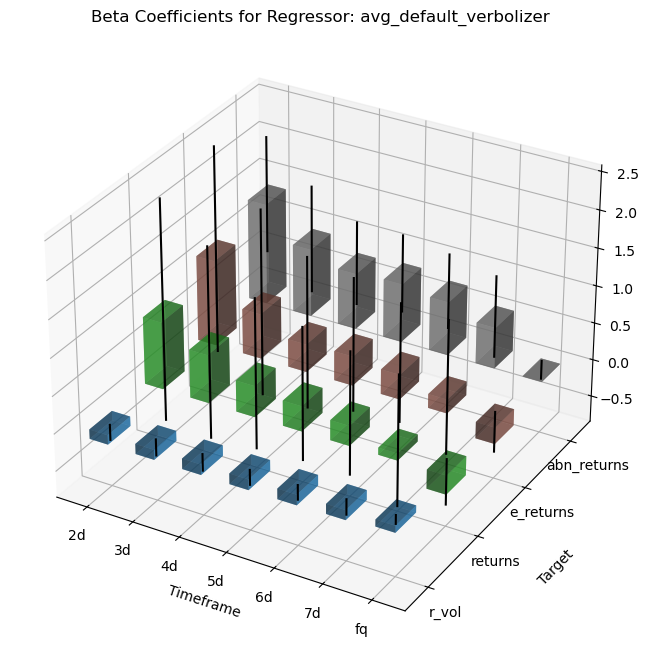

/tmp/ipykernel_9593/3646329875.py:396: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


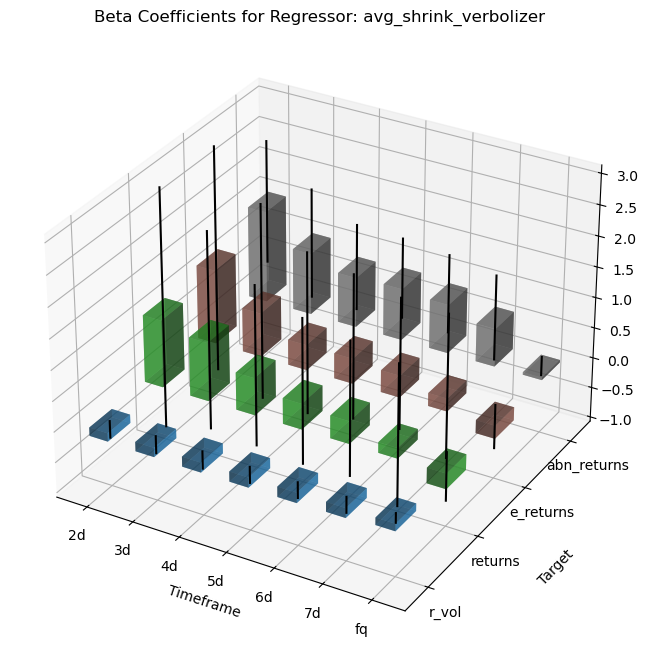

/tmp/ipykernel_9593/3646329875.py:396: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


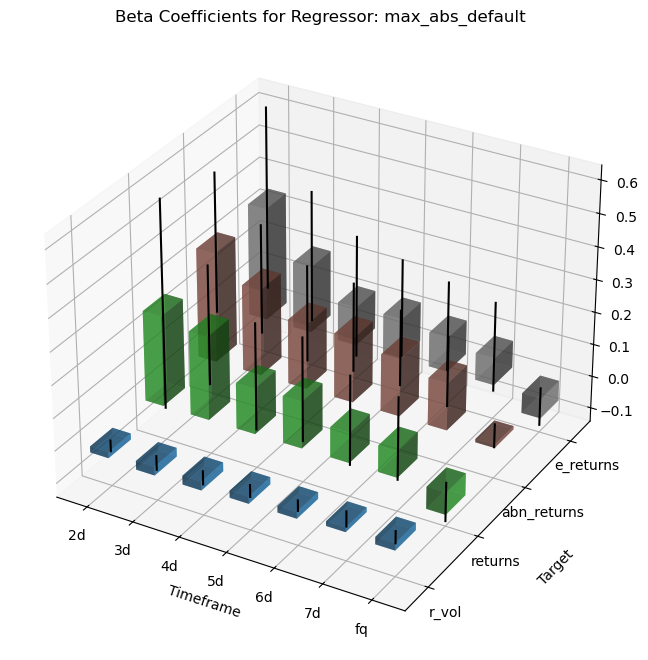

/tmp/ipykernel_9593/3646329875.py:396: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


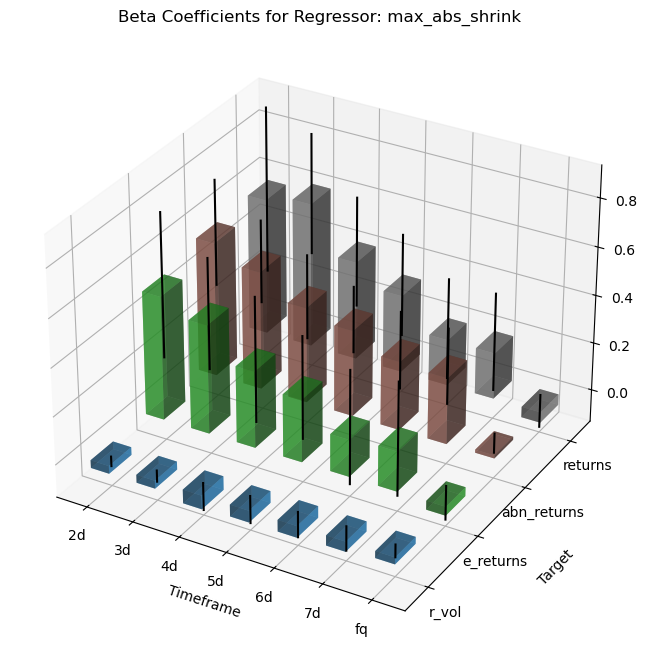

/tmp/ipykernel_9593/3646329875.py:396: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


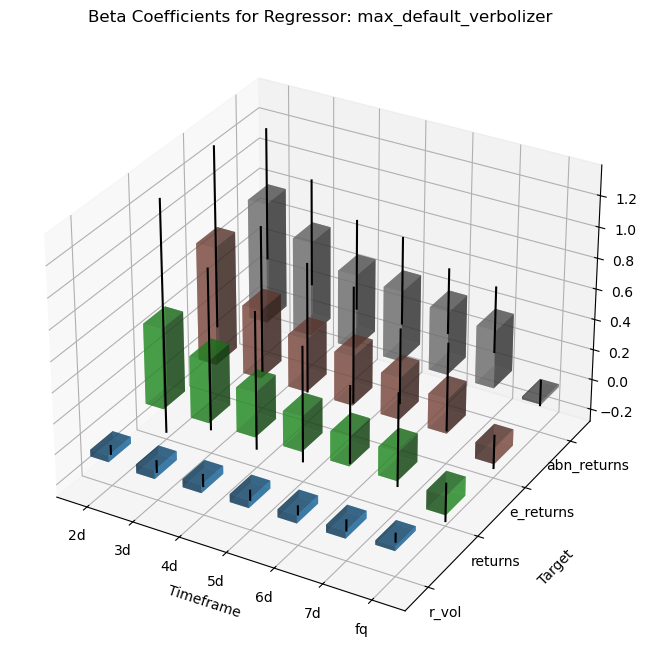

/tmp/ipykernel_9593/3646329875.py:396: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


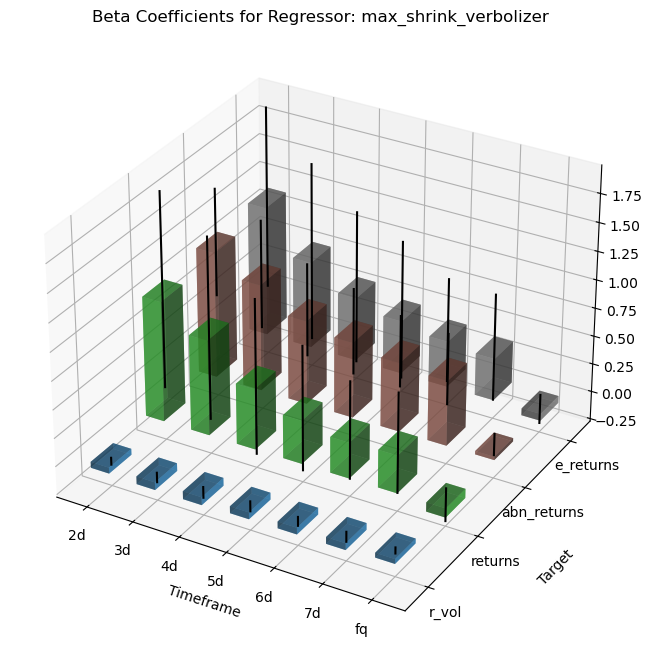

/tmp/ipykernel_9593/3646329875.py:396: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


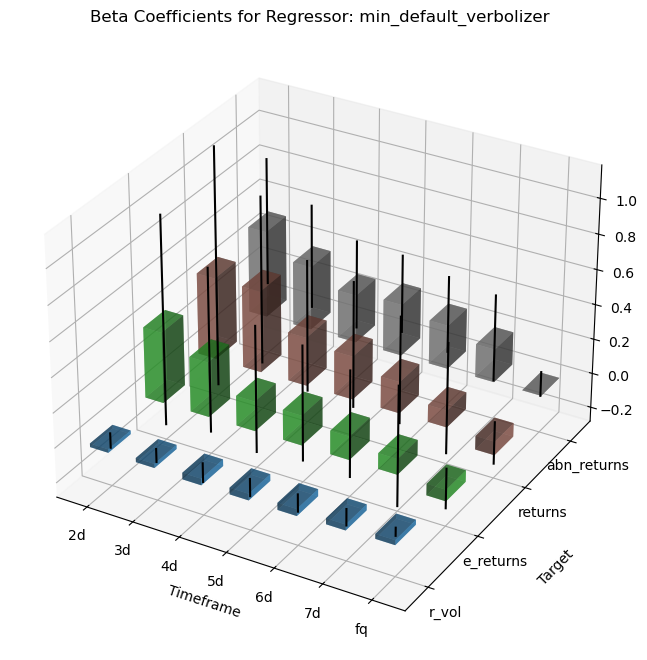

/tmp/ipykernel_9593/3646329875.py:396: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


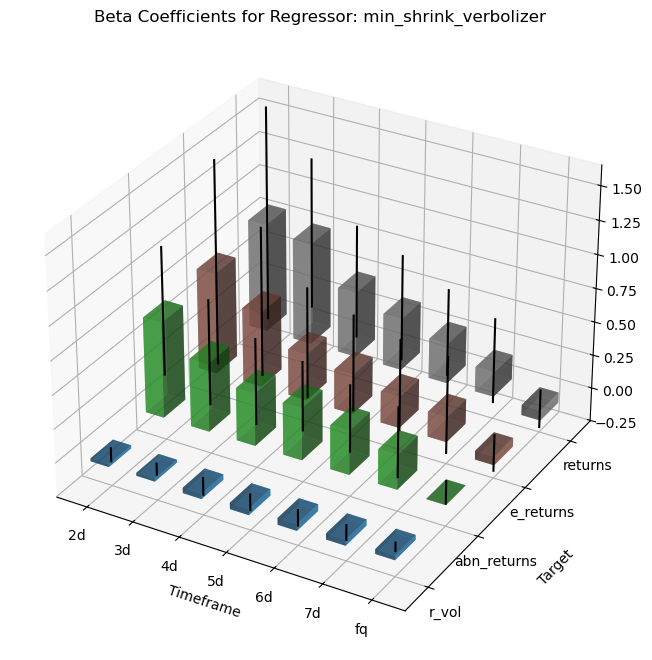

In [13]:
model.graph_3d()

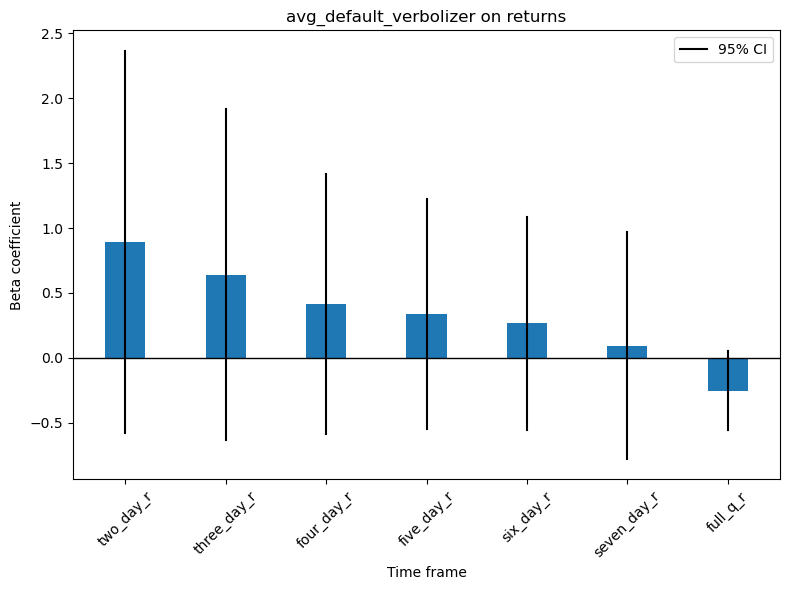

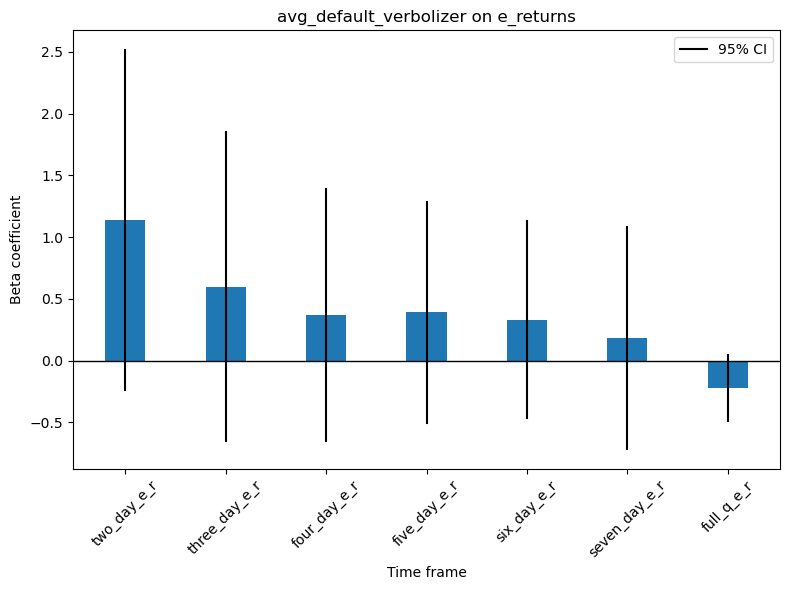

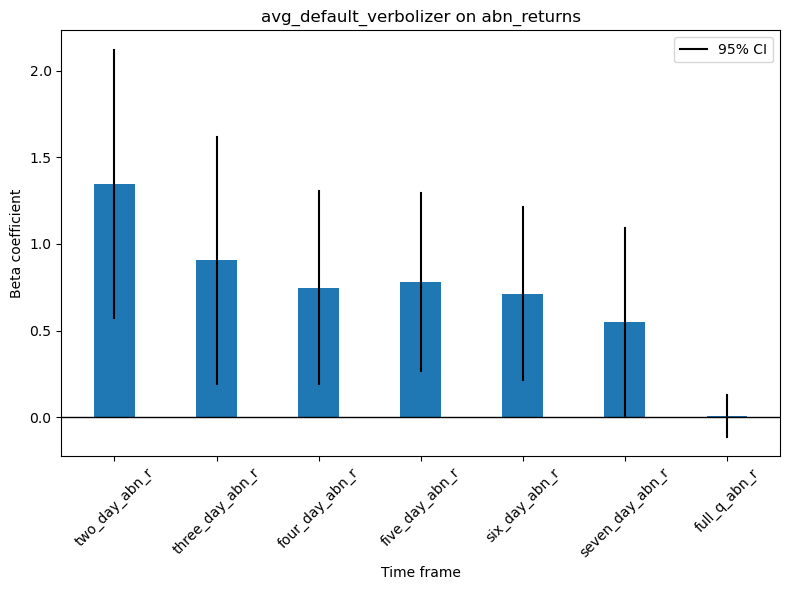

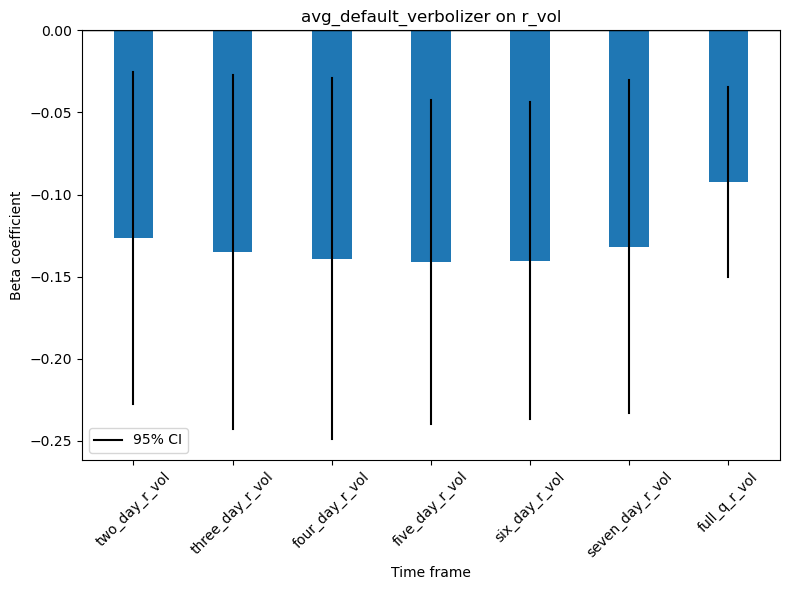

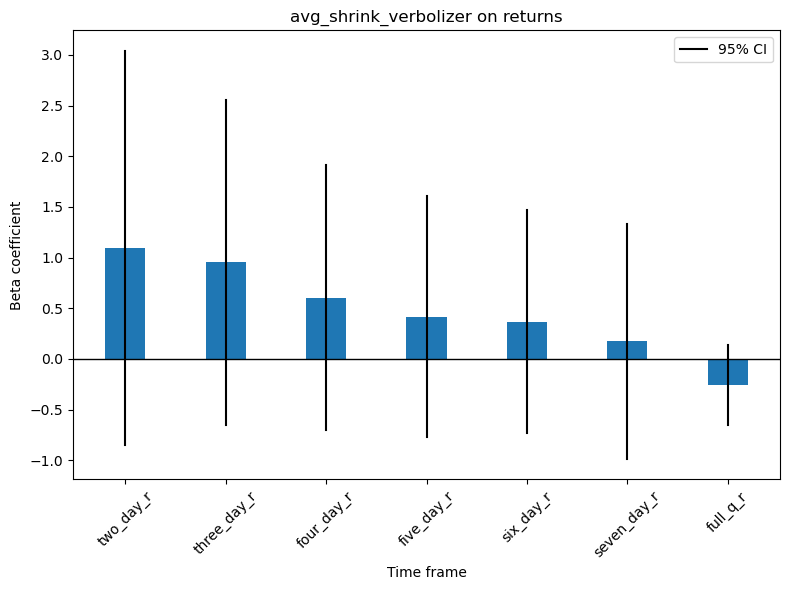

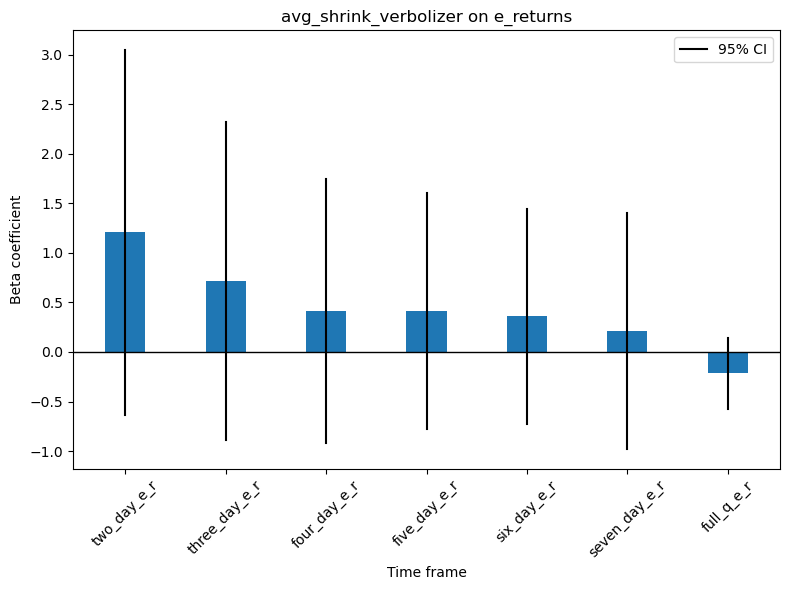

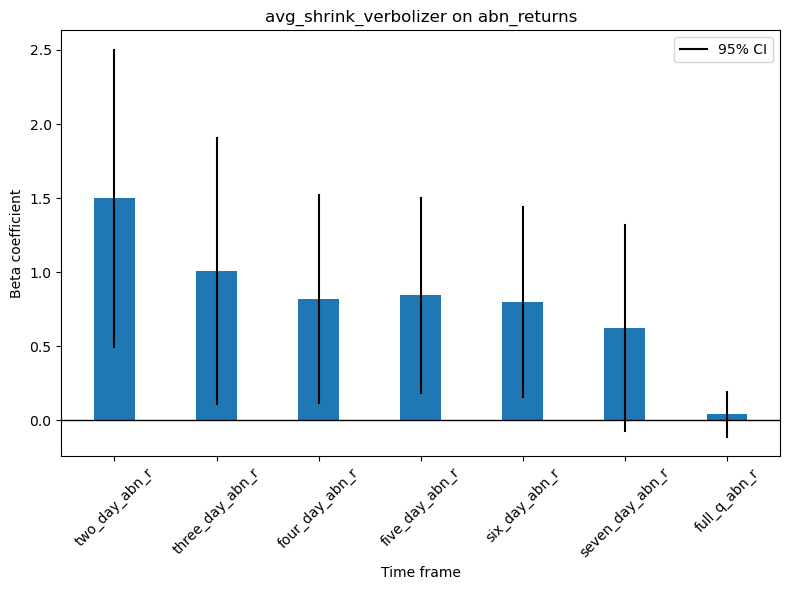

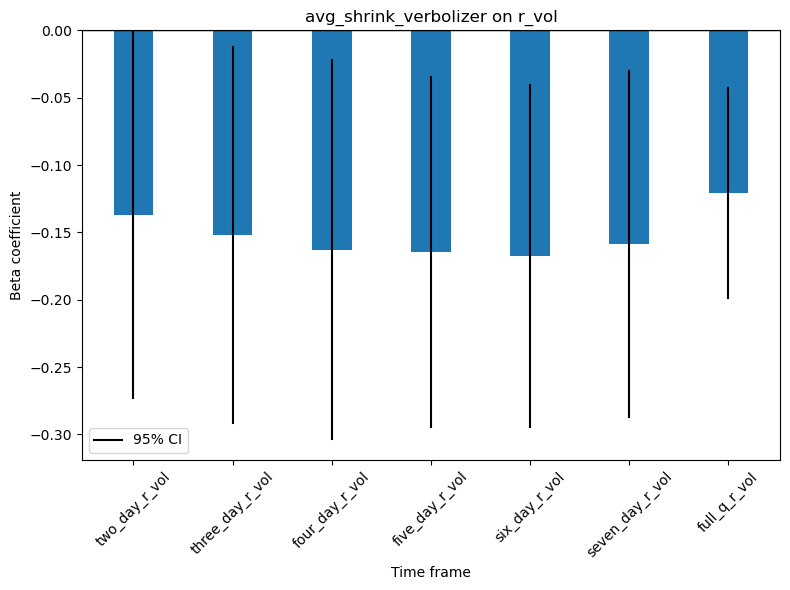

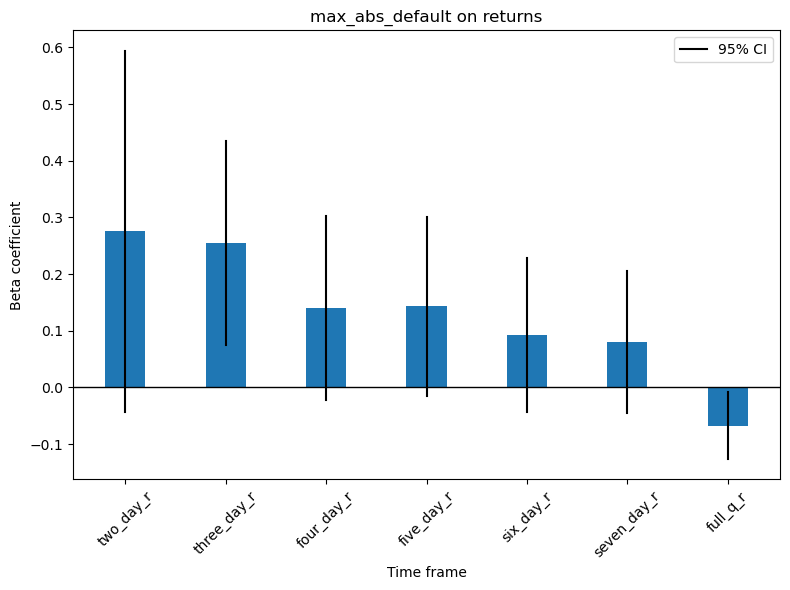

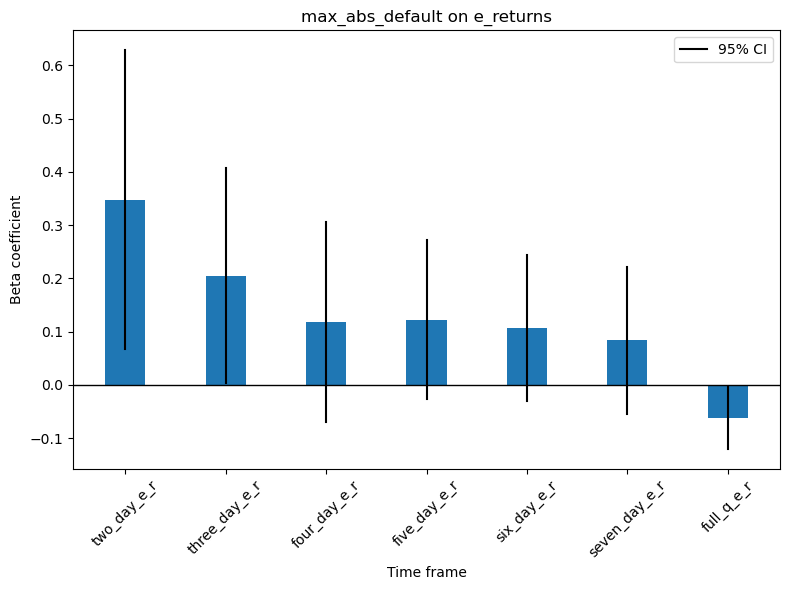

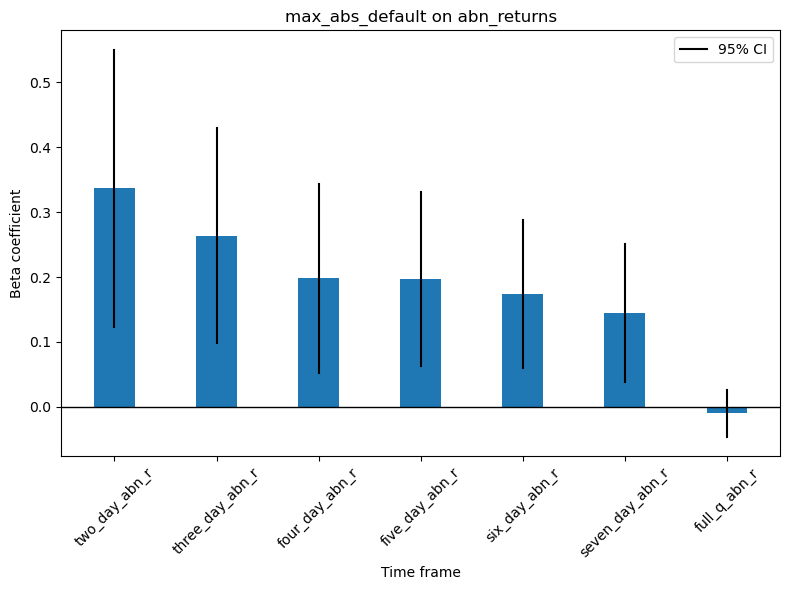

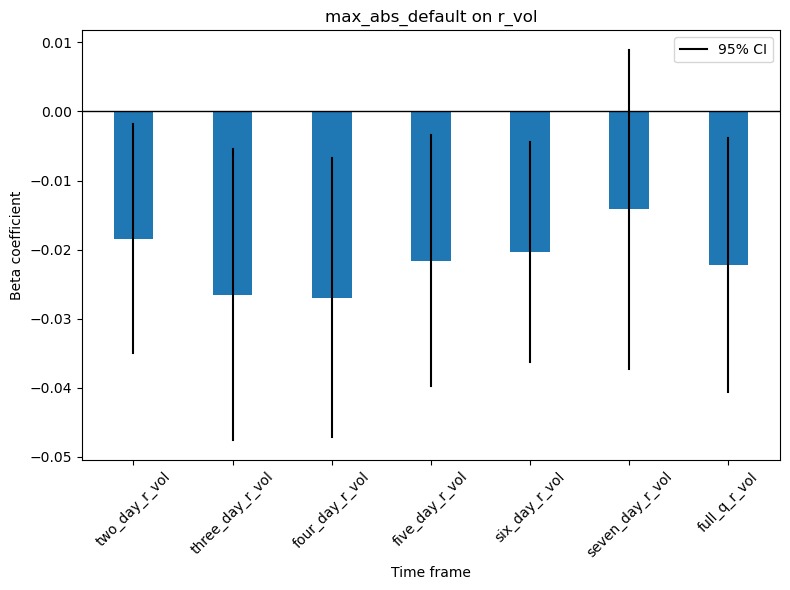

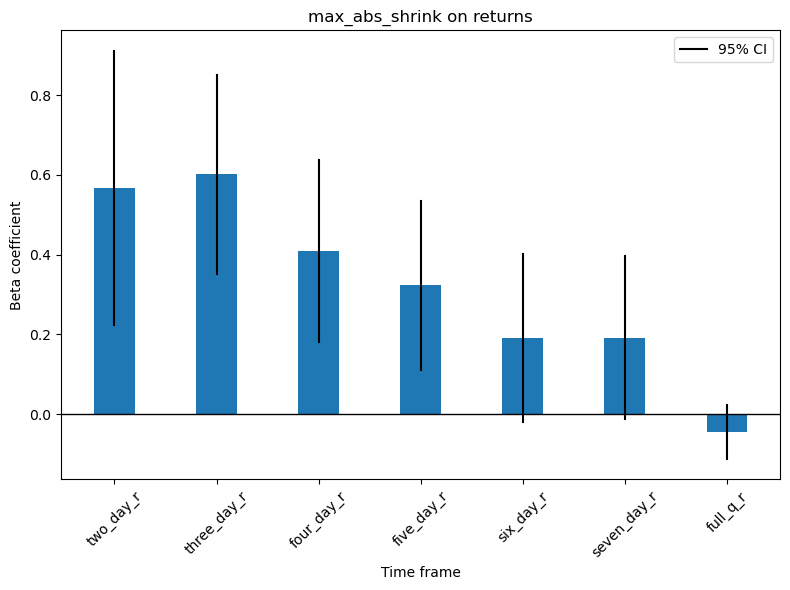

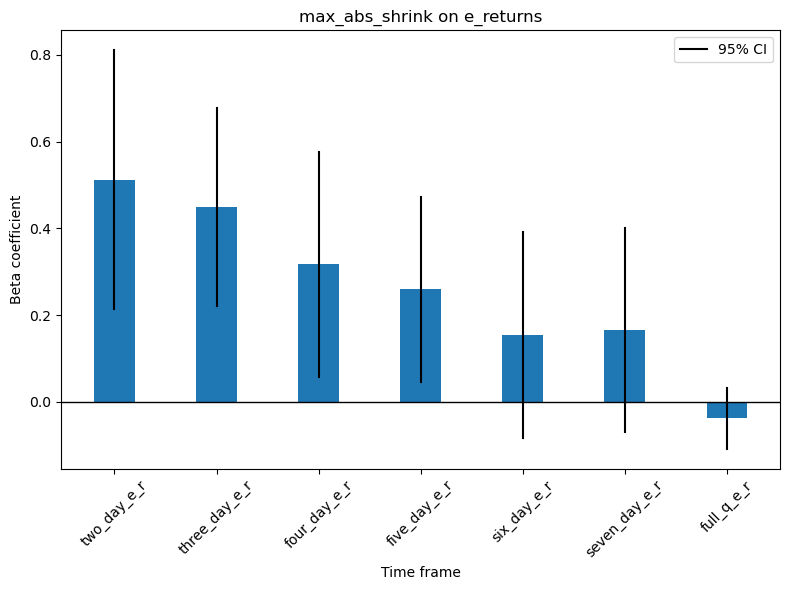

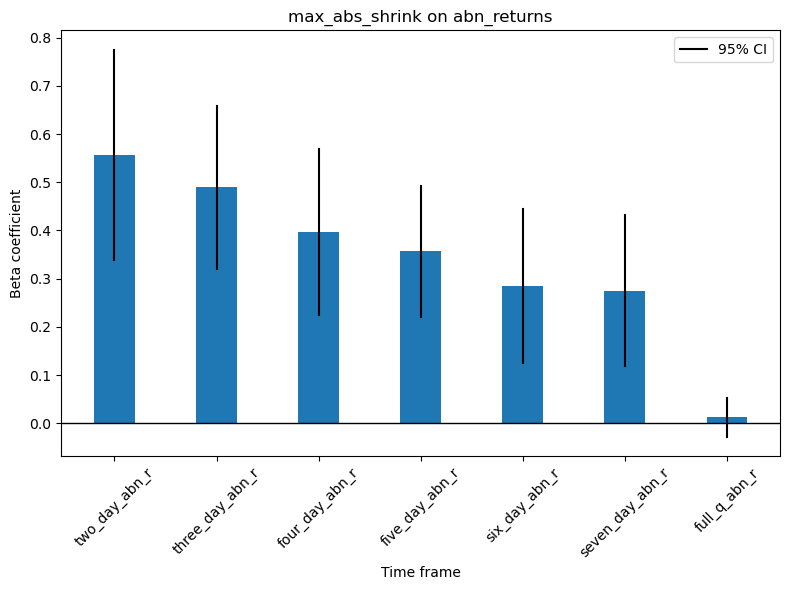

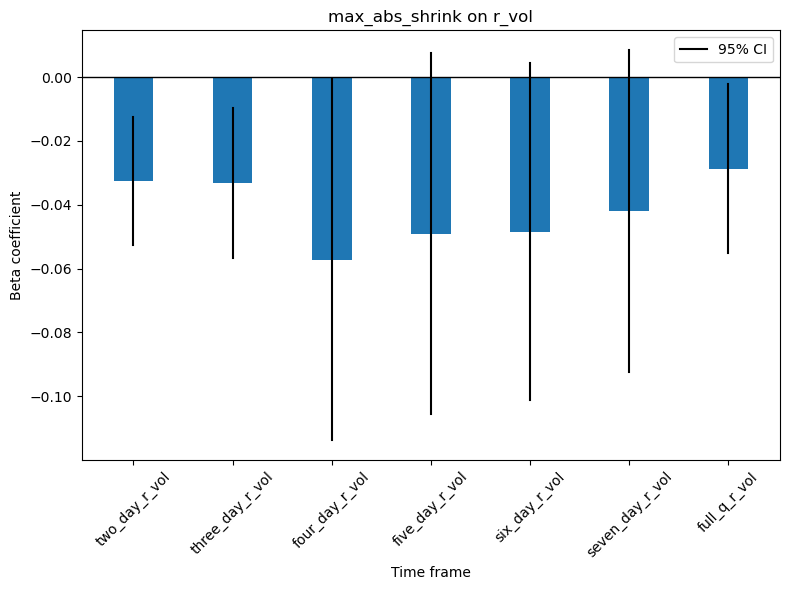

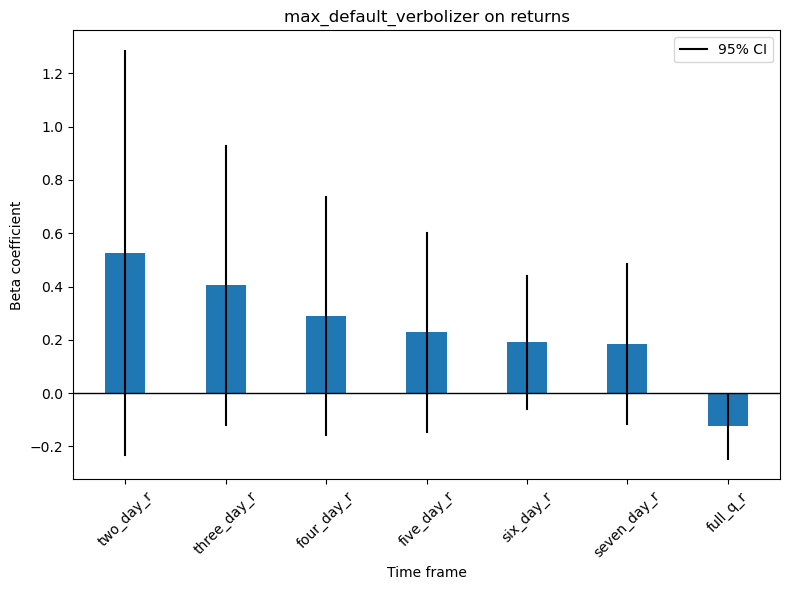

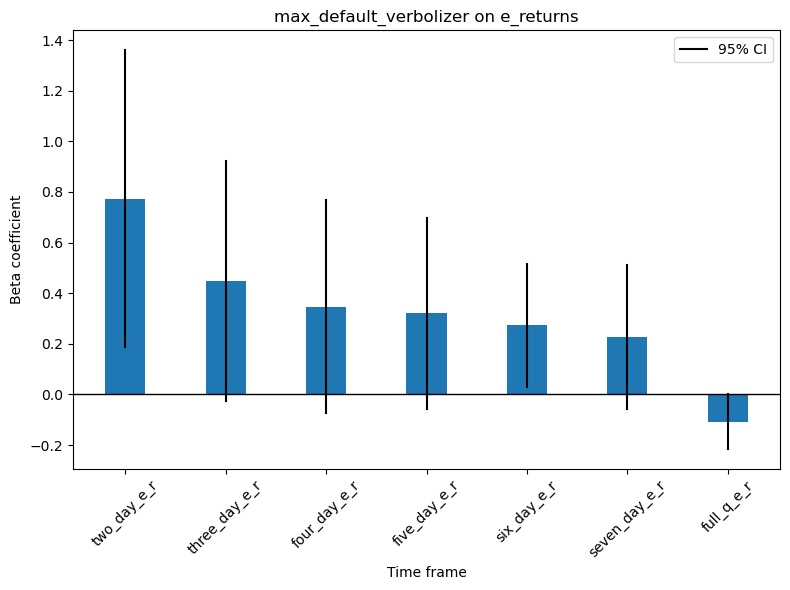

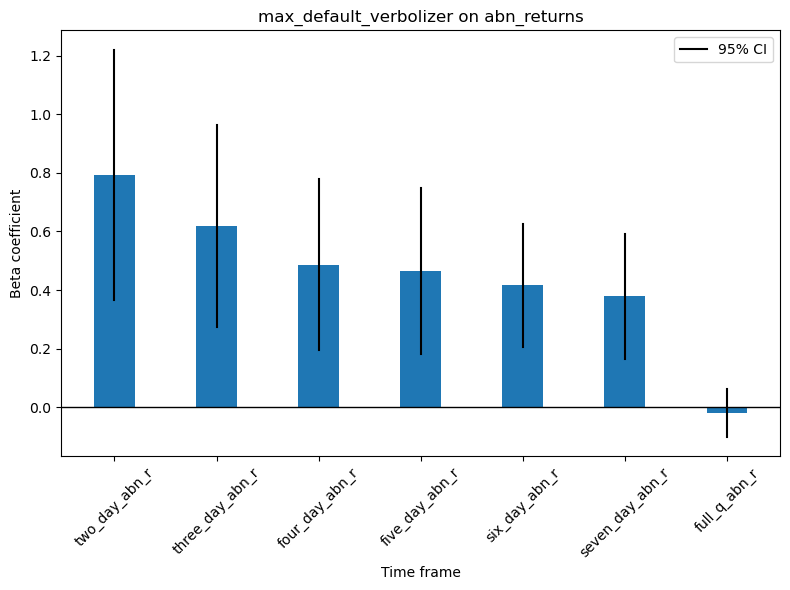

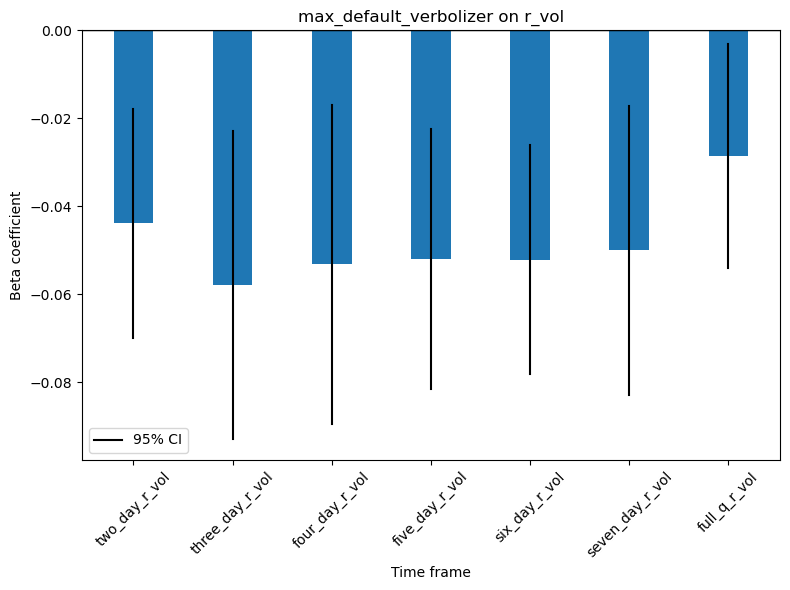

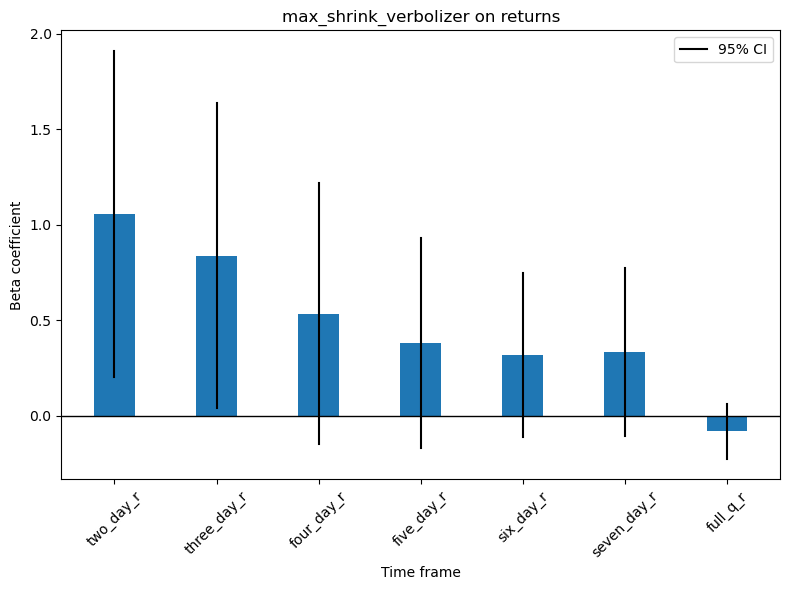

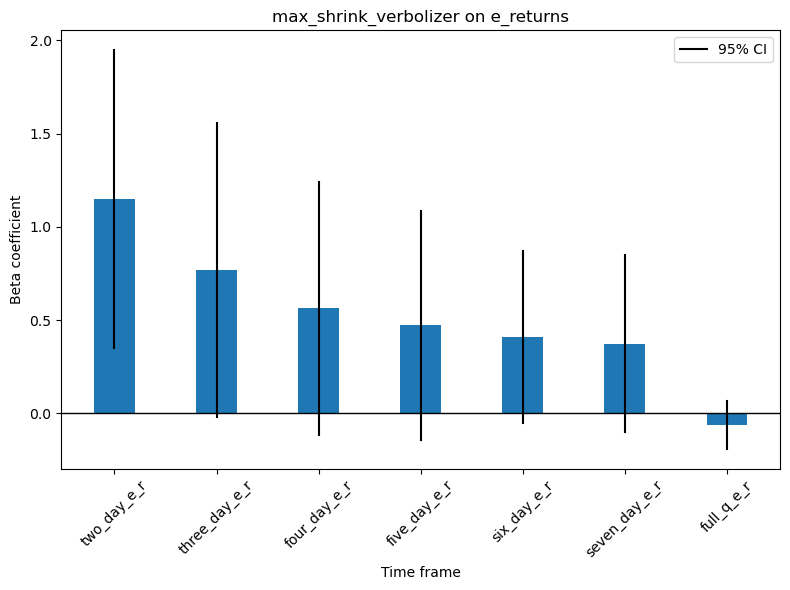

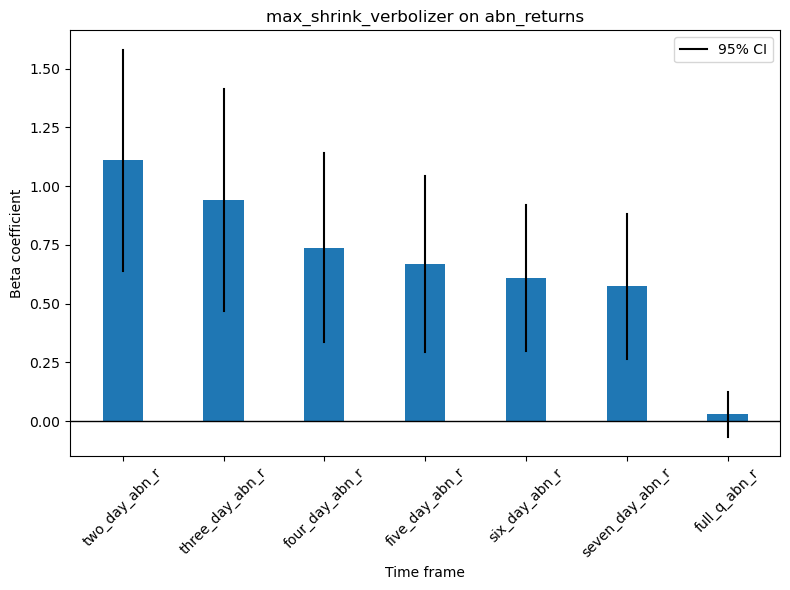

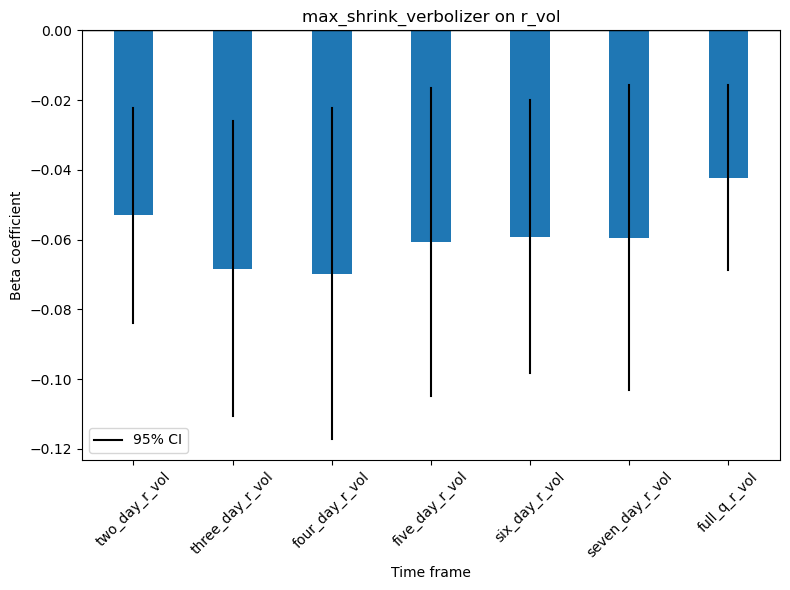

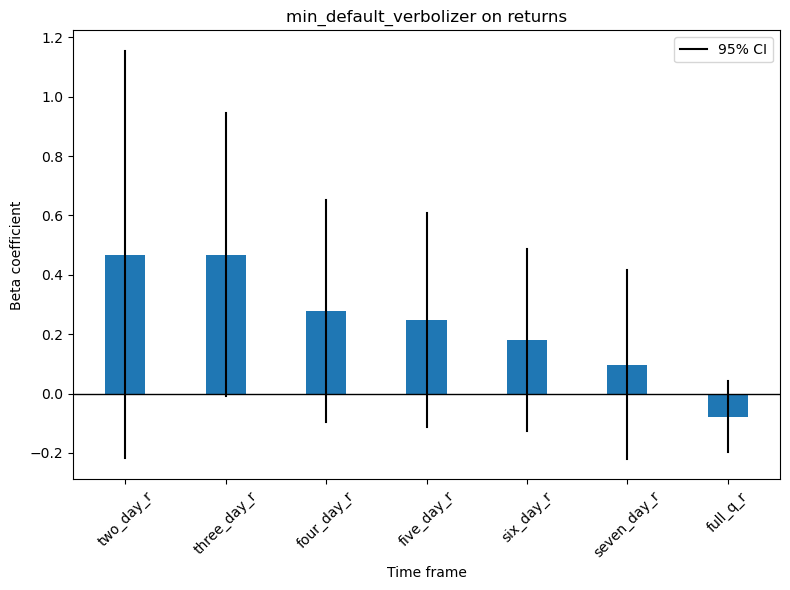

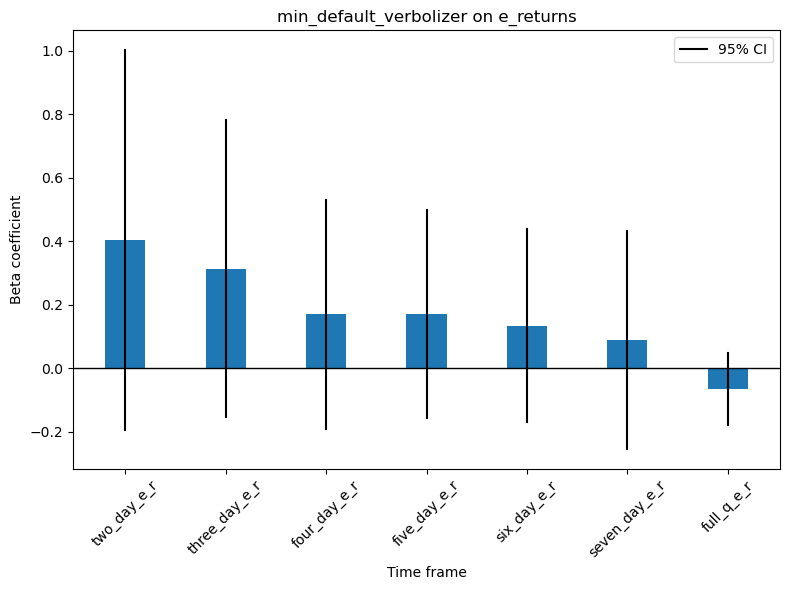

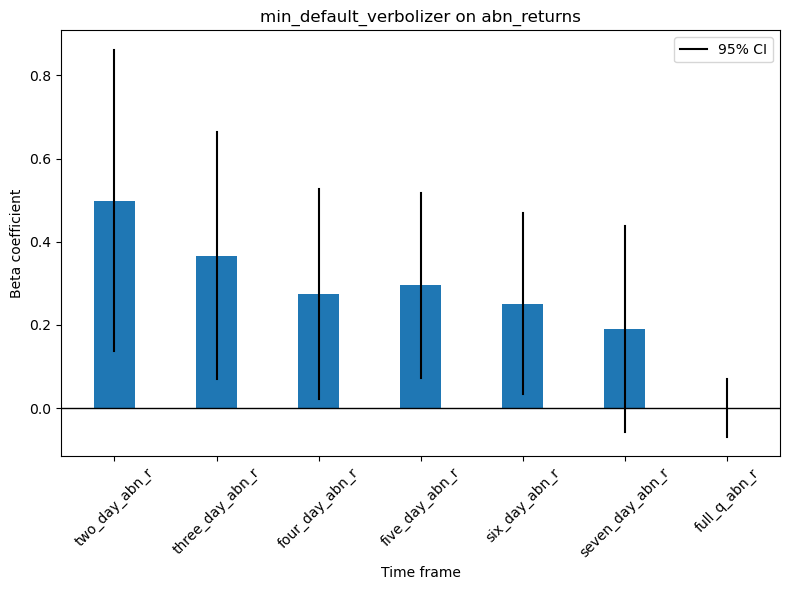

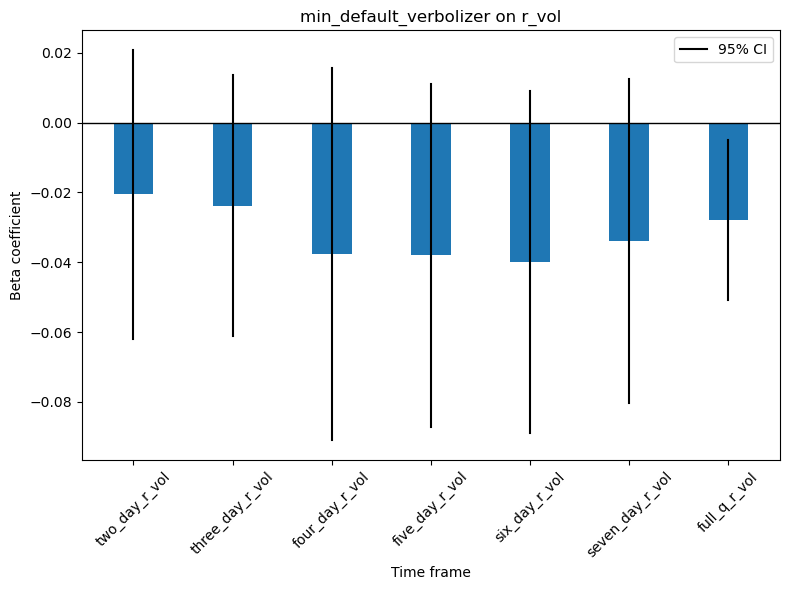

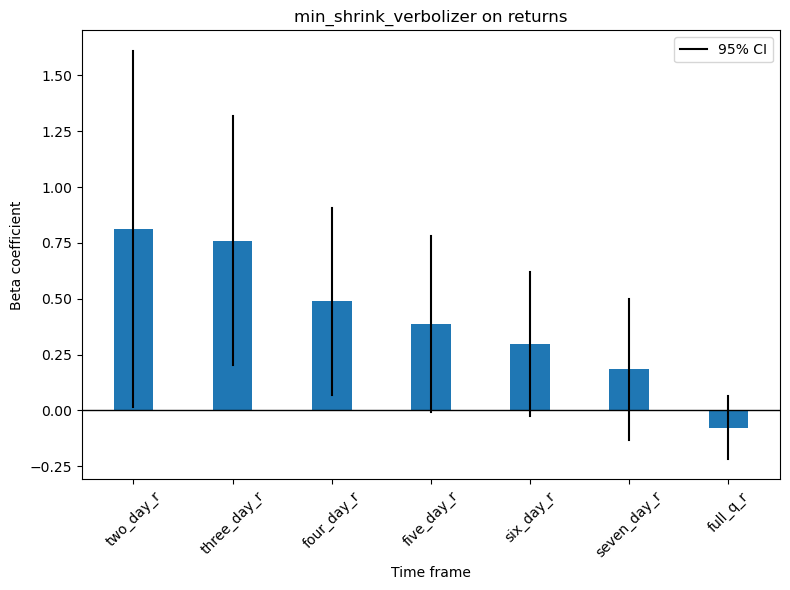

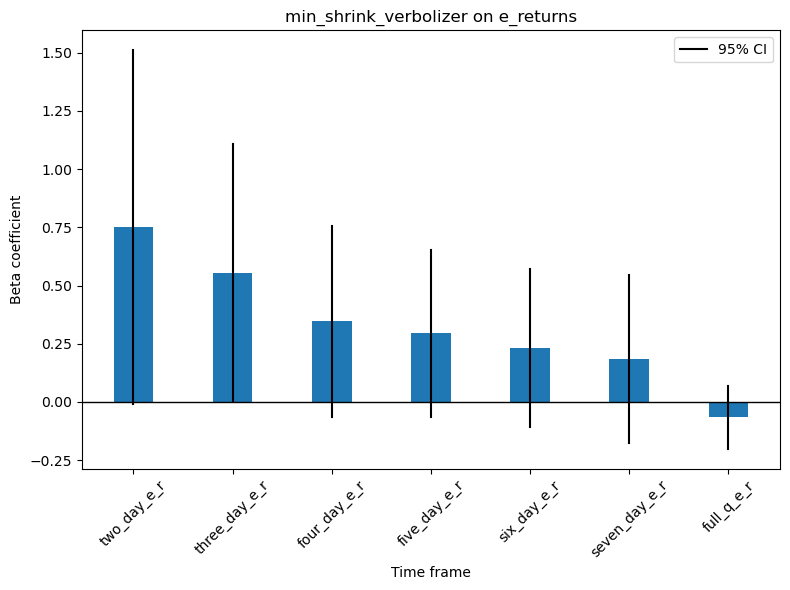

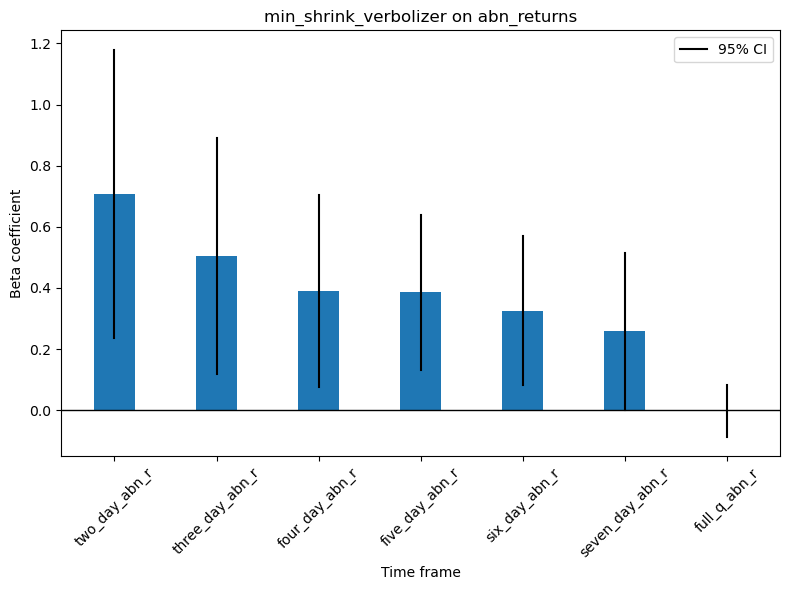

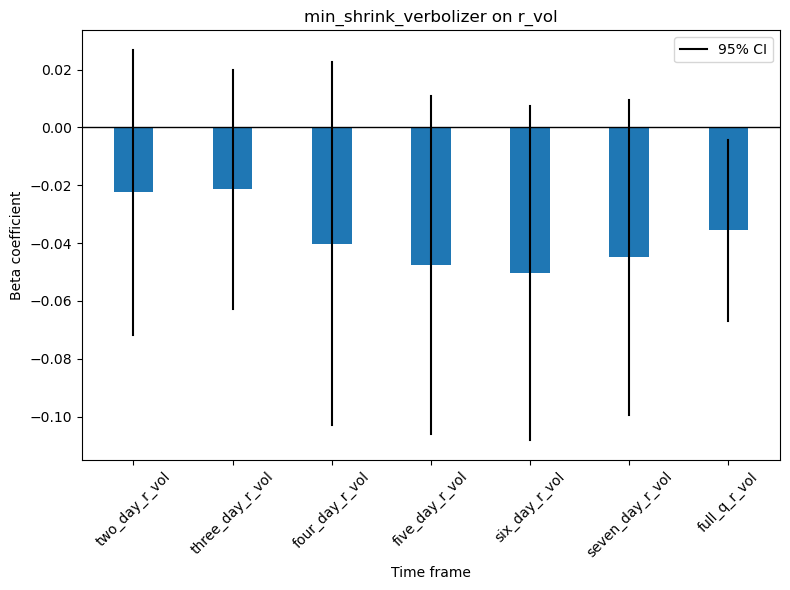

In [14]:
model.plot_all_params()